In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
# Uploading data
def load_data(path):
    dataset = pd.read_csv(path, header=0, delimiter=';')
    return(dataset)

# Demographic dataset
demographic = load_data('20211025_ADNI_demographics.csv')

# Volums dataset
volume = pd.read_table('20211025_HSvolumes.txt', header=0, sep=' ')

Let's work first with the demographic data.

In [3]:
demographic

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,10,bl,011_S_0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1.0,NaN,NaN,NaN,NaN
1,10,m06,011_S_0010,ADNI1,ADNI1,09/05/2006,AD,73.9,Female,12.0,1.0,NaN,NaN,NaN,NaN
2,10,m12,011_S_0010,ADNI1,ADNI1,09/11/2006,AD,73.9,Female,12.0,1.0,NaN,NaN,NaN,NaN
3,10,m18,011_S_0010,ADNI1,ADNI1,10/05/2007,AD,73.9,Female,12.0,1.0,NaN,NaN,NaN,NaN
4,10,m24,011_S_0010,ADNI1,ADNI1,07/11/2007,AD,73.9,Female,12.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,999,bl,029_S_0999,ADNI1,ADNI1,21/12/2006,AD,70.8,Male,12.0,0.0,NaN,NaN,NaN,NaN
15509,999,m06,029_S_0999,ADNI1,ADNI1,13/09/2007,AD,70.8,Male,12.0,0.0,NaN,NaN,NaN,NaN
15510,999,m12,029_S_0999,ADNI1,ADNI1,11/03/2008,AD,70.8,Male,12.0,0.0,NaN,NaN,NaN,NaN
15511,999,m18,029_S_0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0.0,NaN,NaN,NaN,NaN


As can be seen, some columns were created, 'Unnamed: 1X', apparently empty. We need to check whether this columns are truely empty.

In [4]:
demographic[['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']].describe()

,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


As the count is 0 in all columns and, all the other stats form the selected columns are NaN, we can be positive about this columns being empty, therefore, we can drop them from the dataset.

In [5]:
# Dropping empty columns
demographic = demographic.drop(['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], axis=1)

Now, we need to check if all the columns have their suitable class, in other words, the columns that have type int values, are class int, etc.

In [6]:
# Checking class types
for i in demographic.columns:
    print(i, ':', demographic[i].dtypes)

RID : object
VISCODE2 : object
PTID : object
COLPROT : object
ORIGPROT : object
EXAMDATE : object
DX.bl : object
AGE : float64
PTGENDER : object
PTEDUCAT : float64
APOE4 : float64


It is easy to see that the column _RID_ , which is an identificator, and the column _APOE4_ , that keeps the amount of active gens regarding the Alzheimer disease of every chromosome, should be of type int, but, the former is an Object and the latter has been uploaded as a float. Hence, we change the class type of these two columns.

To avoid errors when changing the data type, we will be ignoring theses errors which will be later changed. What is more, the NA from the _APOE4_ column will be filled with the number 99.

In [7]:
# Changing the type from columns 'RID' and 'APOE4'
for i in range(demographic.shape[0]):
    demographic.loc[i,'RID'] = pd.to_numeric(demographic.loc[i,'RID'], errors='ignore')

demographic['APOE4'] = demographic['APOE4'].fillna(99).astype(np.int64)

In [8]:
# Checking all values have been properly changed 
rid_errors = []
apoe_errors = []

for i in range(demographic.shape[0]):
    if type(demographic.loc[i, 'RID']) != np.int64:
        rid_errors.append(i)
    if type(demographic.loc[i, 'APOE4']) != np.int64:
        apoe_errors.append(i)

print('rid errors: ', len(rid_errors))
print('apoe 4 errors: ', len(apoe_errors))

rid errors:  14
apoe 4 errors:  0


In [9]:
# Looking up which data brings up errors
demographic['RID'][rid_errors]

2626    11/09/2007
2638    16/11/2012
2639    16/11/2012
2640    22/01/2013
2641    14/03/2013
2642    14/03/2013
2643    14/03/2013
2644    14/03/2013
2645    14/03/2013
2646    24/11/2014
2647    18/12/2014
2648    24/07/2015
2659    13/02/2019
2660    04/03/2019
Name: RID, dtype: object

Every row that has not chenaged its type has a date as a value, let's check how is the rest of the data of these rows, if the data on the other columns is irrelevant, the rows will be dropped.

In [10]:
demographic.iloc[rid_errors]

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
2626,11/09/2007,00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2638,16/11/2012,09:40:12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2639,16/11/2012,09:40:12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2640,22/01/2013,14:01:31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2641,14/03/2013,19:16:45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2642,14/03/2013,19:16:45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2643,14/03/2013,19:16:46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2644,14/03/2013,19:16:47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2645,14/03/2013,19:16:47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99
2646,24/11/2014,19:16:54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99


In [11]:
# Rows do not have any relevant information. We can delete them.
demographic = demographic.drop(rid_errors, axis=0)

# Rows indexs are reset.
demographic = demographic.reset_index(drop = True)

# The column class is finally defined properly.
demographic['RID'] = pd.to_numeric(demographic['RID'])

In [12]:
# Cheking the types onece again
for i in demographic.columns:
    print(i,': ', demographic[i].dtypes)

RID :  int64
VISCODE2 :  object
PTID :  object
COLPROT :  object
ORIGPROT :  object
EXAMDATE :  object
DX.bl :  object
AGE :  float64
PTGENDER :  object
PTEDUCAT :  float64
APOE4 :  int64


Now that the columns have their suitable class, we can work with them and start to clean the dataset.

Firstly, we check if there are NAs, NULLs or NaNs.

In [13]:
print(demographic.isna().sum())

RID            0
VISCODE2       3
PTID        1632
COLPROT     1632
ORIGPROT    1632
EXAMDATE    1632
DX.bl       1652
AGE         1634
PTGENDER    1632
PTEDUCAT    1632
APOE4          0
dtype: int64


It can be seen how there are some missings in the dataset. It is easy to see how most of the columns have the same number of NAs, therefore, it is not absurd to think that there are full rows without information. Let's check, if this hypothesis is true, looking at, for example, the NAs of a subset created from the rows' indexs where the _PTID_ is a missing.

In [14]:
# Checking how are the rows for the column 'PTID' when this is NULL.
demographic[demographic['PTID'].isna()].isna().sum()

RID            0
VISCODE2       3
PTID        1632
COLPROT     1632
ORIGPROT    1632
EXAMDATE    1632
DX.bl       1632
AGE         1632
PTGENDER    1632
PTEDUCAT    1632
APOE4          0
dtype: int64

The count of NAs confirms our hypothesis. As this rows do not provide any information, they can be removed. Once dropped, we check the number of NAs again.

In [15]:
# Rows do not provide infromation. They can be dropped.
demographic = demographic.drop(demographic.index[demographic['PTID'].isna()].tolist(), axis=0)

# Reseting the rows' indexs
demographic = demographic.reset_index(drop = True)

In [16]:
print(demographic.isnull().sum())

RID          0
VISCODE2     0
PTID         0
COLPROT      0
ORIGPROT     0
EXAMDATE     0
DX.bl       20
AGE          2
PTGENDER     0
PTEDUCAT     0
APOE4        0
dtype: int64


Once the dataset is clean, we can work with it. To fill the data that is still mssing, we need to check if the individual shows up more times in out database. To do so, we first need to create a unique ID for evey pacient. This ID coms from the last 4 digits of the values in the _PTID_ column. Before extracting this ID, we need to check whether all the _PTID_ values follow the same pattern. 

In [17]:
id_error = []
for i in range(demographic.shape[0]):
    check = bool(re.match(r'[0-9][0-9][0-9]_S_[0-9][0-9][0-9][0-9]+', str(demographic['PTID'][i])))
    if not check:
        id_error.append(i)
        
print('id_error: ', len(id_error))

id_error:  0


Since all the _PTID_ values follow the same pattern, we can now extract the patient ID.

In [18]:
# The 'PTID' is transformed into a type int identificator, where we only keep the 4 last digits of the string.
for i in range(demographic.shape[0]):
    demographic.loc[i,'PTID'] = demographic.loc[i,'PTID'].split('_')[2]

demographic

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
0,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1
1,10,m06,0010,ADNI1,ADNI1,09/05/2006,AD,73.9,Female,12.0,1
2,10,m12,0010,ADNI1,ADNI1,09/11/2006,AD,73.9,Female,12.0,1
3,10,m18,0010,ADNI1,ADNI1,10/05/2007,AD,73.9,Female,12.0,1
4,10,m24,0010,ADNI1,ADNI1,07/11/2007,AD,73.9,Female,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...
13862,999,bl,0999,ADNI1,ADNI1,21/12/2006,AD,70.8,Male,12.0,0
13863,999,m06,0999,ADNI1,ADNI1,13/09/2007,AD,70.8,Male,12.0,0
13864,999,m12,0999,ADNI1,ADNI1,11/03/2008,AD,70.8,Male,12.0,0
13865,999,m18,0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0


Now, we can check if we have enough information to fill the missing gaps. But first, we check if any patient has a missing in the _DX.bl_ and _AGE_ column at the same time.

In [19]:
# Searching and keeping the patients index with a missing in DX.bl
dx = demographic[demographic['DX.bl'].isna()].index.to_list()

# Searching and keeping the patients ID with a missing in AGE
age = demographic[demographic['AGE'].isna()].index.to_list()

print(age[0] in dx)
print(age[1] in dx)

False
False


In [20]:
# Searching and keeping the patients PTID with a missing in DX.bl
idxs = demographic[demographic['DX.bl'].isna()]['PTID'].to_list()

# Checking if the patient appears only once in the dataset
pacient = [i for i in idxs if len(demographic[demographic['PTID'] == i]) == 1]

# Number of patients with missings that cannot be filled
print('pacients incomplets: ', len(pacient))

pacients incomplets:  20


In [21]:
# Same process for the AGE column

# Searching and keeping the patients PTID with a missing in AGE
idxs = demographic[demographic['AGE'].isna()]['PTID'].to_list()

# Checking if the patient appears only once in the dataset
pacient = [i for i in idxs if len(demographic[demographic['PTID'] == i]) == 1]

# Number of patients with missings that cannot be filled
print('pacients incomplets: ', len(pacient))

pacients incomplets:  2


Since we do not have more information about the patients with missings, we cannot fill the remaining NAs of the datasat.

In [22]:
# Shwoing the dataset
demographic

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
0,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1
1,10,m06,0010,ADNI1,ADNI1,09/05/2006,AD,73.9,Female,12.0,1
2,10,m12,0010,ADNI1,ADNI1,09/11/2006,AD,73.9,Female,12.0,1
3,10,m18,0010,ADNI1,ADNI1,10/05/2007,AD,73.9,Female,12.0,1
4,10,m24,0010,ADNI1,ADNI1,07/11/2007,AD,73.9,Female,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...
13862,999,bl,0999,ADNI1,ADNI1,21/12/2006,AD,70.8,Male,12.0,0
13863,999,m06,0999,ADNI1,ADNI1,13/09/2007,AD,70.8,Male,12.0,0
13864,999,m12,0999,ADNI1,ADNI1,11/03/2008,AD,70.8,Male,12.0,0
13865,999,m18,0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0


In [23]:
demographic.describe()

,RID,AGE,PTEDUCAT,APOE4
count,13867.000000,13865.000000,13867.000000,13867.000000
mean,2435.142280,73.638082,16.030793,3.967982
std,1973.968659,6.988295,2.809622,18.084465
min,2.000000,54.400000,4.000000,0.000000
25%,658.000000,69.300000,14.000000,0.000000
50%,1402.000000,73.600000,16.000000,0.000000
75%,4421.500000,78.500000,18.000000,1.000000
max,6688.000000,91.400000,20.000000,99.000000


Now, we need to check if we have duplicated data in the _VISCODE2_ column. If so, we need to keep the most recent data; in other words, if we have data from the same month from ADNI1 and ADNI2, we will keep the data from ADNI2. The criteria that we we will follow to choose the newest data is ADNI1 < ADNI2 == ADNIGO < ADNI3, beign ADNI3 the most recent.

In [24]:
# Defining a function to clean duplicates.
def clean_viscode(df):
    # Creating a 'CODE' column to make the variable 'COLPROT' discrete and facilitate the removal of duplicates in 'VISCODE2'
    aux = []
    for i in demographic['COLPROT']:
        if i == 'ADNI1':
            aux.append(1)
        elif (i == 'ADNI2') | (i=='ADNIGO'):
            aux.append(2)
        else:
            aux.append(3)

    demographic['CODE'] = aux
    
    # Finding and removing the duplicates in 'VISCODE2' keepeng the most recent data
    ids = np.unique(df['PTID'])

    for i in ids:
        aux = np.sort(np.unique(df[df['PTID'] == i]['CODE']))
        
        if len(aux) > 1:
            vcode1 = list(df[(df['PTID']==i) & (df['CODE']==aux[0])]['VISCODE2'])
            vcode2 = list(df[(df['PTID']==i) & (df['CODE']==aux[1])]['VISCODE2'])

            for j in vcode1:
                if j in vcode2:
                    df = df.drop(df[(df['PTID']==i) & (df['VISCODE2']==j) & (df['CODE']==aux[0])].index, axis=0)

            if len(aux) == 3:
                vcode3 = list(df[(df['PTID']==i) & (df['CODE']==aux[2])]['VISCODE2'])
                for k in vcode3:
                    if k in vcode2:
                        df = df.drop(df[(df['PTID']==i) & (df['VISCODE2']==k) & (df['CODE']==aux[1])].index, axis=0)
                    elif k in vcode1:
                        df = df.drop(df[(df['PTID']==i) & (df['VISCODE2']==k) & (df['CODE']==aux[0])].index, axis=0)
    
    # Dropping the 'CODE' column
    df = df.drop(['CODE'], axis=1)
    
    return df

In [25]:
demographic = clean_viscode(demographic)
demographic

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
0,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1
1,10,m06,0010,ADNI1,ADNI1,09/05/2006,AD,73.9,Female,12.0,1
2,10,m12,0010,ADNI1,ADNI1,09/11/2006,AD,73.9,Female,12.0,1
3,10,m18,0010,ADNI1,ADNI1,10/05/2007,AD,73.9,Female,12.0,1
4,10,m24,0010,ADNI1,ADNI1,07/11/2007,AD,73.9,Female,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...
13862,999,bl,0999,ADNI1,ADNI1,21/12/2006,AD,70.8,Male,12.0,0
13863,999,m06,0999,ADNI1,ADNI1,13/09/2007,AD,70.8,Male,12.0,0
13864,999,m12,0999,ADNI1,ADNI1,11/03/2008,AD,70.8,Male,12.0,0
13865,999,m18,0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0


Renaming the LMCI and EMCI into MCI in the _DX.bl_ column to simplify the diagnosis variable.

In [26]:
demographic['DX.bl'] = demographic['DX.bl'].replace(['LMCI','EMCI'], 'MCI')
demographic

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4
0,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1
1,10,m06,0010,ADNI1,ADNI1,09/05/2006,AD,73.9,Female,12.0,1
2,10,m12,0010,ADNI1,ADNI1,09/11/2006,AD,73.9,Female,12.0,1
3,10,m18,0010,ADNI1,ADNI1,10/05/2007,AD,73.9,Female,12.0,1
4,10,m24,0010,ADNI1,ADNI1,07/11/2007,AD,73.9,Female,12.0,1
...,...,...,...,...,...,...,...,...,...,...,...
13862,999,bl,0999,ADNI1,ADNI1,21/12/2006,AD,70.8,Male,12.0,0
13863,999,m06,0999,ADNI1,ADNI1,13/09/2007,AD,70.8,Male,12.0,0
13864,999,m12,0999,ADNI1,ADNI1,11/03/2008,AD,70.8,Male,12.0,0
13865,999,m18,0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0


Let's now move into the Volumes data.

In [27]:
volume

,Subject,left_Hippocampal_tail,left_subiculum,left_CA1,left_hippocampal.fissure,left_presubiculum,left_parasubiculum,left_molecular_layer_HP,left_GC.ML.DG,left_CA3,...,right_molecular_layer_HP,right_GC.ML.DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,EstimatedTotalIntraCranialVol,tesla,Subject2
0,002_S_0295_2006-04-18.long.002_S_0295_base15,487.492657,327.976179,589.510606,174.599354,272.535491,60.408881,533.667262,269.668547,189.516546,...,543.709615,308.718922,203.011584,279.522806,11.227023,49.813276,3107.201161,1.632150e+06,1.5,002_S_0295
1,002_S_0295_2006-11-02.long.002_S_0295_base15,481.583775,323.026669,581.659894,174.524682,266.622238,61.182830,525.376257,263.753244,188.474166,...,544.551403,305.331203,203.815660,275.820350,11.552649,48.720478,3098.260861,1.632150e+06,1.5,002_S_0295
2,002_S_0295_2007-05-25.long.002_S_0295_base15,483.527712,320.945081,581.390954,176.763332,271.457167,62.742799,519.918938,260.857266,188.402032,...,534.651122,297.181490,195.443239,268.471630,13.340034,46.887165,3029.386417,1.632150e+06,1.5,002_S_0295
3,002_S_0295_2008-07-23.long.002_S_0295_base15,476.073852,312.427568,566.480496,179.600227,258.348150,60.371602,509.049915,257.656984,185.904461,...,513.740475,291.126845,193.217693,264.251812,12.655924,47.844365,2955.121793,1.632150e+06,1.5,002_S_0295
4,002_S_0295_2009-05-22.long.002_S_0295_base15,456.756437,309.286575,561.825910,184.361214,254.875408,60.173356,500.430294,255.513766,182.372635,...,495.996462,282.284174,192.811543,258.200664,12.909854,45.894515,2856.892667,1.632150e+06,1.5,002_S_0295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,941_S_2060_2010-12-06.long.941_S_2060_base3,510.008069,434.652309,641.353693,205.646666,343.268395,66.967867,615.666120,323.289580,221.834132,...,682.838203,352.202819,263.207536,316.430165,63.788160,57.767932,3878.609570,1.574206e+06,3.0,941_S_2060
6987,941_S_4376_2018-08-15.long.941_S_4376_base3,453.027559,327.263229,486.898003,185.800027,230.286881,40.802894,481.793654,267.062033,206.399976,...,501.685769,300.245262,231.849909,277.542494,21.326558,45.099114,2951.488545,1.421088e+06,3.0,941_S_4376
6988,941_S_4376_2019-09-10.long.941_S_4376_base3,442.356808,310.972214,501.183216,194.760190,229.846896,45.280232,473.162371,264.552458,201.481300,...,487.963099,298.434253,225.676333,273.521594,19.637467,47.529313,2909.044200,1.421088e+06,3.0,941_S_4376
6989,941_S_6080_2017-09-29.long.941_S_6080_base3,388.121980,301.553891,438.582417,135.558350,265.325376,54.252359,410.198783,222.457876,138.655728,...,480.418471,257.353104,197.959873,233.201873,56.858176,41.294456,2872.639734,1.331877e+06,3.0,941_S_6080


In [28]:
# Checking the columns class
for i in volume.columns:
    print(i, ':', volume[i].dtypes)

Subject : object
left_Hippocampal_tail : float64
left_subiculum : float64
left_CA1 : float64
left_hippocampal.fissure : float64
left_presubiculum : float64
left_parasubiculum : float64
left_molecular_layer_HP : float64
left_GC.ML.DG : float64
left_CA3 : float64
left_CA4 : float64
left_fimbria : float64
left_HATA : float64
left_Whole_hippocampus : float64
right_Hippocampal_tail : float64
right_subiculum : float64
right_CA1 : float64
right_hippocampal.fissure : float64
right_presubiculum : float64
right_parasubiculum : float64
right_molecular_layer_HP : float64
right_GC.ML.DG : float64
right_CA3 : float64
right_CA4 : float64
right_fimbria : float64
right_HATA : float64
right_Whole_hippocampus : float64
EstimatedTotalIntraCranialVol : float64
tesla : float64
Subject2 : object


In [29]:
# Trnaforming the 'Subject' column into a type int identificator 
# where we will only be keeping the 4 last digits of the string
for i in range(volume.shape[0]):
    volume.loc[i,'Subject'] = volume.loc[i,'Subject'].split('_')[2]
    
volume

,Subject,left_Hippocampal_tail,left_subiculum,left_CA1,left_hippocampal.fissure,left_presubiculum,left_parasubiculum,left_molecular_layer_HP,left_GC.ML.DG,left_CA3,...,right_molecular_layer_HP,right_GC.ML.DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,EstimatedTotalIntraCranialVol,tesla,Subject2
0,0295,487.492657,327.976179,589.510606,174.599354,272.535491,60.408881,533.667262,269.668547,189.516546,...,543.709615,308.718922,203.011584,279.522806,11.227023,49.813276,3107.201161,1.632150e+06,1.5,002_S_0295
1,0295,481.583775,323.026669,581.659894,174.524682,266.622238,61.182830,525.376257,263.753244,188.474166,...,544.551403,305.331203,203.815660,275.820350,11.552649,48.720478,3098.260861,1.632150e+06,1.5,002_S_0295
2,0295,483.527712,320.945081,581.390954,176.763332,271.457167,62.742799,519.918938,260.857266,188.402032,...,534.651122,297.181490,195.443239,268.471630,13.340034,46.887165,3029.386417,1.632150e+06,1.5,002_S_0295
3,0295,476.073852,312.427568,566.480496,179.600227,258.348150,60.371602,509.049915,257.656984,185.904461,...,513.740475,291.126845,193.217693,264.251812,12.655924,47.844365,2955.121793,1.632150e+06,1.5,002_S_0295
4,0295,456.756437,309.286575,561.825910,184.361214,254.875408,60.173356,500.430294,255.513766,182.372635,...,495.996462,282.284174,192.811543,258.200664,12.909854,45.894515,2856.892667,1.632150e+06,1.5,002_S_0295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,2060,510.008069,434.652309,641.353693,205.646666,343.268395,66.967867,615.666120,323.289580,221.834132,...,682.838203,352.202819,263.207536,316.430165,63.788160,57.767932,3878.609570,1.574206e+06,3.0,941_S_2060
6987,4376,453.027559,327.263229,486.898003,185.800027,230.286881,40.802894,481.793654,267.062033,206.399976,...,501.685769,300.245262,231.849909,277.542494,21.326558,45.099114,2951.488545,1.421088e+06,3.0,941_S_4376
6988,4376,442.356808,310.972214,501.183216,194.760190,229.846896,45.280232,473.162371,264.552458,201.481300,...,487.963099,298.434253,225.676333,273.521594,19.637467,47.529313,2909.044200,1.421088e+06,3.0,941_S_4376
6989,6080,388.121980,301.553891,438.582417,135.558350,265.325376,54.252359,410.198783,222.457876,138.655728,...,480.418471,257.353104,197.959873,233.201873,56.858176,41.294456,2872.639734,1.331877e+06,3.0,941_S_6080


In [30]:
print(volume.isnull().sum())

Subject                           0
left_Hippocampal_tail            74
left_subiculum                   74
left_CA1                         74
left_hippocampal.fissure         74
left_presubiculum                74
left_parasubiculum               74
left_molecular_layer_HP          74
left_GC.ML.DG                    74
left_CA3                         74
left_CA4                         74
left_fimbria                     74
left_HATA                        74
left_Whole_hippocampus           74
right_Hippocampal_tail           74
right_subiculum                  74
right_CA1                        74
right_hippocampal.fissure        74
right_presubiculum               74
right_parasubiculum              74
right_molecular_layer_HP         74
right_GC.ML.DG                   74
right_CA3                        74
right_CA4                        74
right_fimbria                    74
right_HATA                       74
right_Whole_hippocampus          74
EstimatedTotalIntraCranialVo

In [31]:
# Searching and keeping the patients Subject with a missing volume value
idxs = []
for i in volume.columns[1:-3]:
    #idxs.append(volume[volume[i].isna()]['Subject'].to_list())
    idxs.append(volume.index[volume['left_Hippocampal_tail'].isna()].to_list())
    
# Checking wwether all the missing values are from the same group of patients
all(i == idxs[0] for i in idxs)

True

As all missing values are from the same group of patients we can use the first list of indexs of the list to visualize the data.

In [32]:
volume.iloc[idxs[0]]

,Subject,left_Hippocampal_tail,left_subiculum,left_CA1,left_hippocampal.fissure,left_presubiculum,left_parasubiculum,left_molecular_layer_HP,left_GC.ML.DG,left_CA3,...,right_molecular_layer_HP,right_GC.ML.DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,EstimatedTotalIntraCranialVol,tesla,Subject2
26,0782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710979e+06,1.5,002_S_0782
27,0782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710979e+06,1.5,002_S_0782
28,0782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710979e+06,1.5,002_S_0782
29,0782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.710979e+06,1.5,002_S_0782
540,0557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.591840e+06,1.5,014_S_0557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5202,4590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.512525e+06,3.0,031_S_4590
5203,4590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.512525e+06,3.0,031_S_4590
6129,2168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.711155e+06,3.0,068_S_2168
6130,2168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.711155e+06,3.0,068_S_2168


Since all the values are indeed missing, we can drop this rows in a new dataset.

In [33]:
volume_clean = volume[~volume.index.isin(idxs[0])]
volume_clean

,Subject,left_Hippocampal_tail,left_subiculum,left_CA1,left_hippocampal.fissure,left_presubiculum,left_parasubiculum,left_molecular_layer_HP,left_GC.ML.DG,left_CA3,...,right_molecular_layer_HP,right_GC.ML.DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,EstimatedTotalIntraCranialVol,tesla,Subject2
0,0295,487.492657,327.976179,589.510606,174.599354,272.535491,60.408881,533.667262,269.668547,189.516546,...,543.709615,308.718922,203.011584,279.522806,11.227023,49.813276,3107.201161,1.632150e+06,1.5,002_S_0295
1,0295,481.583775,323.026669,581.659894,174.524682,266.622238,61.182830,525.376257,263.753244,188.474166,...,544.551403,305.331203,203.815660,275.820350,11.552649,48.720478,3098.260861,1.632150e+06,1.5,002_S_0295
2,0295,483.527712,320.945081,581.390954,176.763332,271.457167,62.742799,519.918938,260.857266,188.402032,...,534.651122,297.181490,195.443239,268.471630,13.340034,46.887165,3029.386417,1.632150e+06,1.5,002_S_0295
3,0295,476.073852,312.427568,566.480496,179.600227,258.348150,60.371602,509.049915,257.656984,185.904461,...,513.740475,291.126845,193.217693,264.251812,12.655924,47.844365,2955.121793,1.632150e+06,1.5,002_S_0295
4,0295,456.756437,309.286575,561.825910,184.361214,254.875408,60.173356,500.430294,255.513766,182.372635,...,495.996462,282.284174,192.811543,258.200664,12.909854,45.894515,2856.892667,1.632150e+06,1.5,002_S_0295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,2060,510.008069,434.652309,641.353693,205.646666,343.268395,66.967867,615.666120,323.289580,221.834132,...,682.838203,352.202819,263.207536,316.430165,63.788160,57.767932,3878.609570,1.574206e+06,3.0,941_S_2060
6987,4376,453.027559,327.263229,486.898003,185.800027,230.286881,40.802894,481.793654,267.062033,206.399976,...,501.685769,300.245262,231.849909,277.542494,21.326558,45.099114,2951.488545,1.421088e+06,3.0,941_S_4376
6988,4376,442.356808,310.972214,501.183216,194.760190,229.846896,45.280232,473.162371,264.552458,201.481300,...,487.963099,298.434253,225.676333,273.521594,19.637467,47.529313,2909.044200,1.421088e+06,3.0,941_S_4376
6989,6080,388.121980,301.553891,438.582417,135.558350,265.325376,54.252359,410.198783,222.457876,138.655728,...,480.418471,257.353104,197.959873,233.201873,56.858176,41.294456,2872.639734,1.331877e+06,3.0,941_S_6080


In [34]:
# Checking if all the missings were dropped correctly
print(volume_clean.isnull().sum())

Subject                          0
left_Hippocampal_tail            0
left_subiculum                   0
left_CA1                         0
left_hippocampal.fissure         0
left_presubiculum                0
left_parasubiculum               0
left_molecular_layer_HP          0
left_GC.ML.DG                    0
left_CA3                         0
left_CA4                         0
left_fimbria                     0
left_HATA                        0
left_Whole_hippocampus           0
right_Hippocampal_tail           0
right_subiculum                  0
right_CA1                        0
right_hippocampal.fissure        0
right_presubiculum               0
right_parasubiculum              0
right_molecular_layer_HP         0
right_GC.ML.DG                   0
right_CA3                        0
right_CA4                        0
right_fimbria                    0
right_HATA                       0
right_Whole_hippocampus          0
EstimatedTotalIntraCranialVol    0
tesla               

In [35]:
# Saving the cleaned volumes dataset
with open('volumes_clean.txt', 'w') as f:
    dfAsString = volume_clean.to_string(header=True, index=False)
    f.write(dfAsString)
f.close()

Now, we copy the data from the _EstimatedTotalIntraCranialVol_ from the Volume dataset to a new _IntraCranialVol_ column in the demographic dataset for each patient and save the merged information in a _data_ dataset.

In [36]:
data = pd.merge(demographic, volume_clean[['Subject','EstimatedTotalIntraCranialVol']], left_on='PTID', right_on = 'Subject')
data = data.drop(['Subject'], axis=1)
data = data.rename(columns={'EstimatedTotalIntraCranialVol':'IntraCranialVol'})
data

,RID,VISCODE2,PTID,COLPROT,ORIGPROT,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4,IntraCranialVol
0,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1,1.499132e+06
1,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1,1.499132e+06
2,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1,1.499132e+06
3,10,bl,0010,ADNI1,ADNI1,10/11/2005,AD,73.9,Female,12.0,1,1.499132e+06
4,10,m06,0010,ADNI1,ADNI1,09/05/2006,AD,73.9,Female,12.0,1,1.499132e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
63238,999,m18,0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0,1.452337e+06
63239,999,m18,0999,ADNI1,ADNI1,17/06/2008,AD,70.8,Male,12.0,0,1.452337e+06
63240,999,m24,0999,ADNI1,ADNI1,09/01/2009,AD,70.8,Male,12.0,0,1.452337e+06
63241,999,m24,0999,ADNI1,ADNI1,09/01/2009,AD,70.8,Male,12.0,0,1.452337e+06


We hypothesize that the variables _VISCODE2_ and _AGE_ are corralated since both of them represent time, however, _AGE_ contains a single value as its the age of the pacient at their first diagnosis. Since _AGE_ is easier to interpret, we will change its value following the _VISCODE2_ values.

Basically we are setting the "bl" as 0 and all the other values of _VISCODE2_ are set as _#months_ / 12 and then we add all the _VISCODE2_ column to the _AGE_ column.

In [37]:
data['VISCODE2'] = [int(i[1:]) if i != 'bl' else 0 for i in data['VISCODE2']]
data['VISCODE2'] = data['VISCODE2']/12
data['AGE'] += data['VISCODE2']

Let's check the correlation between both changed variables.

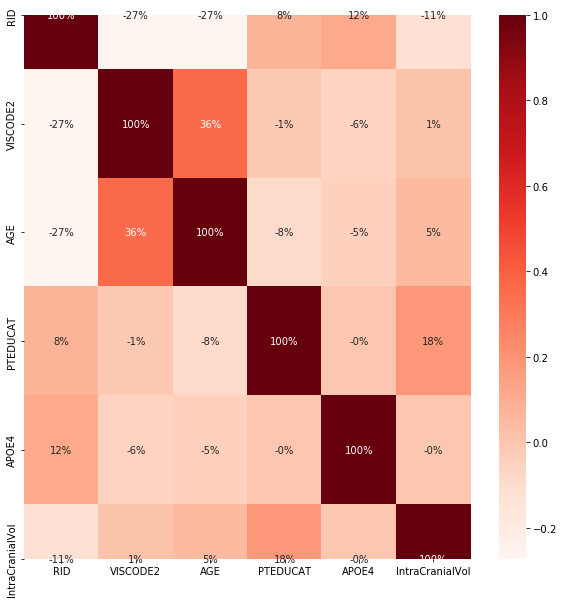

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),annot=True, fmt='.0%', cmap='Reds')

Although the correlation is not sginificative enough to say that both variables will create the model equally, we will keep de _AGE_ column this way and use it to create our models.

Now that all the data is cleaned and ready to use, we save the datasets as .txt files.

In [39]:
with open('data.txt', 'w') as f:
    dfAsString = data.to_string(header=True, index=False)
    f.write(dfAsString)
f.close()

A way to simplify the study of all the hippocampal regions is to add up both sides of each region. Hence, we will save a dataset with this sum.

In [40]:
volume

,Subject,left_Hippocampal_tail,left_subiculum,left_CA1,left_hippocampal.fissure,left_presubiculum,left_parasubiculum,left_molecular_layer_HP,left_GC.ML.DG,left_CA3,...,right_molecular_layer_HP,right_GC.ML.DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,EstimatedTotalIntraCranialVol,tesla,Subject2
0,0295,487.492657,327.976179,589.510606,174.599354,272.535491,60.408881,533.667262,269.668547,189.516546,...,543.709615,308.718922,203.011584,279.522806,11.227023,49.813276,3107.201161,1.632150e+06,1.5,002_S_0295
1,0295,481.583775,323.026669,581.659894,174.524682,266.622238,61.182830,525.376257,263.753244,188.474166,...,544.551403,305.331203,203.815660,275.820350,11.552649,48.720478,3098.260861,1.632150e+06,1.5,002_S_0295
2,0295,483.527712,320.945081,581.390954,176.763332,271.457167,62.742799,519.918938,260.857266,188.402032,...,534.651122,297.181490,195.443239,268.471630,13.340034,46.887165,3029.386417,1.632150e+06,1.5,002_S_0295
3,0295,476.073852,312.427568,566.480496,179.600227,258.348150,60.371602,509.049915,257.656984,185.904461,...,513.740475,291.126845,193.217693,264.251812,12.655924,47.844365,2955.121793,1.632150e+06,1.5,002_S_0295
4,0295,456.756437,309.286575,561.825910,184.361214,254.875408,60.173356,500.430294,255.513766,182.372635,...,495.996462,282.284174,192.811543,258.200664,12.909854,45.894515,2856.892667,1.632150e+06,1.5,002_S_0295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,2060,510.008069,434.652309,641.353693,205.646666,343.268395,66.967867,615.666120,323.289580,221.834132,...,682.838203,352.202819,263.207536,316.430165,63.788160,57.767932,3878.609570,1.574206e+06,3.0,941_S_2060
6987,4376,453.027559,327.263229,486.898003,185.800027,230.286881,40.802894,481.793654,267.062033,206.399976,...,501.685769,300.245262,231.849909,277.542494,21.326558,45.099114,2951.488545,1.421088e+06,3.0,941_S_4376
6988,4376,442.356808,310.972214,501.183216,194.760190,229.846896,45.280232,473.162371,264.552458,201.481300,...,487.963099,298.434253,225.676333,273.521594,19.637467,47.529313,2909.044200,1.421088e+06,3.0,941_S_4376
6989,6080,388.121980,301.553891,438.582417,135.558350,265.325376,54.252359,410.198783,222.457876,138.655728,...,480.418471,257.353104,197.959873,233.201873,56.858176,41.294456,2872.639734,1.331877e+06,3.0,941_S_6080


To begin with, we will only be working with 3 regions: the hippocampal tail, the subiculum and the CA1.

In [63]:
add_vol = pd.DataFrame(volume_clean['Subject'].copy())
add_vol['hippocampal_tail'] = volume_clean['left_Hippocampal_tail'] + volume_clean['right_Hippocampal_tail']
add_vol['subiculum'] = volume_clean['left_subiculum'] + volume_clean['right_subiculum']
add_vol['CA1'] = volume_clean['left_CA1'] + volume_clean['right_CA1']
add_vol['hippocampal.fissure'] = volume_clean['left_hippocampal.fissure'] + volume_clean['right_hippocampal.fissure']
add_vol['presubiculum'] = volume_clean['left_presubiculum'] + volume_clean['right_presubiculum']
add_vol['HP'] = volume_clean['left_molecular_layer_HP'] + volume_clean['right_molecular_layer_HP']
add_vol['GC'] = volume_clean['left_GC.ML.DG'] + volume_clean['right_GC.ML.DG']
add_vol['CA3'] = volume_clean['left_CA3'] + volume_clean['right_CA3']
add_vol['CA4'] = volume_clean['left_CA4'] + volume_clean['right_CA4']
add_vol['fimbria'] = volume_clean['left_fimbria'] + volume_clean['right_fimbria']
add_vol['HATA'] = volume_clean['left_HATA'] + volume_clean['right_HATA']
add_vol['Whole_hippocampus'] = volume_clean['left_Whole_hippocampus'] + volume_clean['right_Whole_hippocampus']

add_vol

,Subject,hippocampal_tail,subiculum,CA1,hippocampal.fissure,presubiculum,HP,GC,CA3,CA4,fimbria,HATA,Whole_hippocampus
0,0295,1037.124758,663.606159,1161.395821,408.444300,488.557849,1077.376877,578.387469,392.528130,536.649150,31.075431,95.397097,6160.535904
1,0295,1021.589127,655.143661,1158.265111,408.250501,488.234922,1069.927660,569.084447,392.289826,525.651737,28.237318,91.920505,6099.656018
2,0295,1002.948503,655.458442,1153.205792,421.303267,483.217191,1054.570060,558.038756,383.845271,514.986690,35.272532,91.563237,6031.751994
3,0295,988.223466,629.223177,1116.360493,426.270266,471.914264,1022.790390,548.783829,379.122154,509.037214,26.459128,90.883768,5883.062831
4,0295,948.075712,613.053855,1098.263789,437.794699,453.175118,996.426756,537.797940,375.184178,500.153723,27.975019,89.042581,5738.293339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6986,2060,1042.372651,911.979532,1391.145080,389.140600,655.068168,1298.504323,675.492399,485.041668,616.550692,125.332285,108.362661,7447.909118
6987,4376,907.171567,686.020314,1017.415956,413.149841,420.020870,983.479423,567.307295,438.249885,520.544672,54.100640,87.404984,5763.104905
6988,4376,896.155498,661.811557,1030.093974,438.571312,413.150356,961.125470,562.986711,427.157633,510.285794,43.369444,84.663926,5675.510487
6989,6080,899.160298,610.290423,937.401790,290.983344,498.105743,890.617254,479.810980,336.615601,433.489445,131.319051,82.374754,5407.616890


In [64]:
with open('added_volumes.txt', 'w') as f:
    dfAsString = add_vol.to_string(header=True, index=False)
    f.write(dfAsString)
f.close()